In [15]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, least_squares
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext Cython

# Functions

In [16]:
%%cython
import numpy as np
cimport numpy as np
cimport cython

cpdef np.ndarray cnorm(np.ndarray[double] x):
    
    cdef double e = 2.7182818284590452353602874
    cdef double pi = 3.14159265358979323846 
    
    return (1/np.sqrt(2*pi))*(e**(-np.multiply(x, x)/2))

In [17]:
def CE_1_cy(Y, X, arg, r):
    
    n_arg = np.shape(arg)[0]
    n = np.shape(X)[0]
    h = (n**(-r)) * np.std(X, axis = 0, ddof = 1)
    e = np.zeros((n_arg, 1))
    
    for j in range(0, n_arg):
        temp = np.array(np.divide((arg[j] - X), h)).flatten()
        k = np.divide(cnorm(temp), h)
        k = np.prod(k, axis = 0).T  
        e[j] = (Y.T*k/n)/np.mean(k)
        
    return e

In [115]:
# Trimming function
def trim(X, percent):
    
    alpha = (1 - percent)/2
    n, k = np.shape(X)
    t_ind = np.zeros((n, k))
    
    for i in range(0, k):
        upper_bd = np.percentile(X[:,i], (1 - alpha)*100)
        lower_bd = np.percentile(X[:,i], (alpha)*100)
        t_ind[:, i] = [int(lower_bd < x < upper_bd) for x in X[:,i]]
        
    return np.prod(t_ind, axis = 1)

# Conditional Expectation
def CE_1(Y, X, arg, r):
    
    n_arg = np.shape(arg)[0]
    n = np.shape(X)[0]
    h = (n**(-r)) * np.std(X, axis = 0, ddof = 1)
    e = np.zeros((n_arg, 1))
    
    for j in range(0, n_arg):
        k = np.divide(norm.pdf(np.divide((arg[j] - X), h)), h)
        k = np.prod(k, axis = 1)   
        e[j] = (Y.T*k/n)/np.mean(k)
        
    return e

# Semiparametric Least Squares objective
def SLS_1(b, Y, X, X_ind):
    
    v = X * np.matrix(b).T
    EY = CE_1_cy(Y, v, v, 1/5)
    residual = np.power((Y - EY), 2)
    
    return (-0.5 * np.matrix(X_ind)*residual)

# Regress Y on X with SLS
def run_semiparametric_regression(Y, X, guess, trim_percent = 0.98, xtol = 0.001, maxiter = 1):
    
    obj_f = lambda x_0: -1e6*SLS_1(np.append(np.array([1]), x_0), Y, X, trim(X, 0.98))[0,0]
    print('    Running LS...')
    result = least_squares(obj_f, list(np.array(guess).flatten()), xtol = xtol)
    print('    BFGS...')
    result = minimize(obj_f, list(np.array(guess).flatten()), method='BFGS', options = {'maxiter': maxiter})
    return result

# Hessian to Covariance matrix
def convert_hessian_to_cov(Y, X, results):
    
    sigma_2_hat = np.mean(np.power(Y - X*np.matrix(results.x).T, 2))
    return results.hess_inv * sigma_2_hat

# Marginal effects at a point using CE_1
def compute_marginal_effect(Y, X, ind, point, beta, delta = 0.01):

    point_nudge = np.copy(point)
    point_nudge[0, ind] = point_nudge[0, ind] + delta
    point_nudge = np.matrix(point_nudge)
    
    v_hat = X*beta
    v_hat_avg = point*beta
    v_hat_avg_nudge = point_nudge*beta
    
    return np.asscalar(CE_1(Y, v_hat, v_hat_avg_nudge, 1/5) - CE_1(Y, v_hat, v_hat_avg, 1/5))/delta

# Range of marginal effects 
def calculate_me_range(Y, X, result, ind, point, delta = .001, delta_range = [0.0001, 0.01], parameter_range = [0, 0.014], n_1 = 200, n_2 = 5):

    beta = np.matrix(result.x).T
    
    me_results = np.zeros(shape = (n_1, 2, n_2))
    
    linspace_1 = np.linspace(parameter_range[0], parameter_range[1], num = n_1)
    linspace_2 = np.linspace(delta_range[0], delta_range[1], num = n_2)
    
    for j in range(0, n_2):

        delta = linspace_2[j]
        #primp_avgt = np.linspace(0.001, 0.5, num = n_2)[j]

        for i in range(0, n_1):
  
            point_temp = np.copy(point)
            point_temp[0, ind] = linspace_1[i]
            
            me_vec = compute_marginal_effect(Y, X, ind, point_temp, beta, delta = delta)

            me_results[i,:,j] = np.array([linspace_1[i], np.asscalar(me_vec)])
            
    return me_results   

# T-stats with first coefficient fixed
def find_tstats(Y, X, results):
    
    V = convert_hessian_to_cov(Y, X, results)

    n = np.shape(results.x)[0]
    theta = results.x/results.x[0]
    t_stats = np.zeros(shape = (n))
    t_stats[0] = np.nan # first t-stat is unknown

    for i in range(1, n):
        t_stats[i] = theta[i] / np.sqrt(V[i,i])

    return t_stats

# Params

In [109]:
workbook_file_loc = '../analysis/results/semiparametric_regressions_test2.xlsx'
sample_query = 'Broker == "AXA" & OrderType == "Market" & Exchange == "NYSE"'

# Load Data

In [110]:
data_df = pd.read_csv('../data/processed/regression_data_levels_demeaned.csv').dropna()
data_df['PrImp_Pct_Rebate_Dummy'] = data_df['PrImp_Pct'] * data_df['Rebate_Dummy']
data_df['PrImp_AvgAmt_Rebate_Dummy'] = data_df['PrImp_AvgAmt'] * data_df['Rebate_Dummy']
data_df['PrImp_ExpAmt_Rebate_Dummy'] = data_df['PrImp_ExpAmt'] * data_df['Rebate_Dummy']
data_df['PrImp_AvgT_Rebate_Dummy'] = data_df['PrImp_AvgT'] * data_df['Rebate_Dummy']
data_df['All_AvgT_Rebate_Dummy'] = data_df['All_AvgT'] * data_df['Rebate_Dummy']

In [111]:
############### Test

sample_frac = 1 # None => All obs
data_df = data_df.sample(frac = sample_frac).query(sample_query)

print('Market Centers: ', end = '') 
print(data_df['MarketCenter'].unique())

print('Brokers: ', end = '') 
print(data_df['Broker'].unique())

print('Samples: %d' % data_df.shape[0])
print('Sparsity: %0.2f%%' % (100*data_df.query('MktShare == 0').shape[0] / data_df.shape[0]))

Market Centers: ['G1ES' 'UBSS' 'FBCO' 'VRTU' 'SGMA' 'CDRG']
Brokers: ['AXA']
Samples: 50
Sparsity: 0.00%


# Regressions 

In [112]:
# Fits
fit1_formula = 'MktShare ~ PrImp_Pct + PrImp_AvgAmt + PrImp_AvgT'
fit2_formula = 'MktShare ~ PrImp_ExpAmt + PrImp_AvgT'
fit3_formula = 'MktShare ~ PrImp_Pct + PrImp_AvgAmt + All_AvgT'
fit4_formula = 'MktShare ~ PrImp_ExpAmt + All_AvgT'

# fit1_formula = 'MktShare ~ PrImp_Pct + PrImp_Pct_Rebate_Dummy + PrImp_AvgAmt + PrImp_AvgAmt_Rebate_Dummy + PrImp_AvgT + PrImp_AvgT_Rebate_Dummy'
# fit2_formula = 'MktShare ~ PrImp_ExpAmt + PrImp_ExpAmt_Rebate_Dummy + PrImp_AvgT + PrImp_AvgT_Rebate_Dummy'
# fit3_formula = 'MktShare ~ PrImp_Pct + PrImp_Pct_Rebate_Dummy + PrImp_AvgAmt + PrImp_AvgAmt_Rebate_Dummy + All_AvgT + All_AvgT_Rebate_Dummy'
# fit4_formula = 'MktShare ~ PrImp_ExpAmt + PrImp_ExpAmt_Rebate_Dummy + All_AvgT + All_AvgT_Rebate_Dummy'


formulaCols = lambda x: x.replace(' ', '').replace('~', '+').split('+') 
fit_formulae = [fit1_formula, fit2_formula, fit3_formula, fit4_formula]
fit_formulae = [formulaCols(x) for x in fit_formulae]

# Store results
fit_results = [None] * len(fit_formulae)

## Results

In [113]:
for i in range(0, len(fit_formulae)):
    
    ## Get results
    print('Regressing with fit %d...' % i )
    
    data = data_df[fit_formulae[i]]
    X = np.matrix(data)[:, 1:]
    Y = np.matrix(data)[:, 0]

    beta_guess, _, _ , _ = np.linalg.lstsq(X, Y, rcond = -1)
    results = run_semiparametric_regression(Y, X, beta_guess[1:]/beta_guess[0], xtol = .00001, maxiter = 50)
    print('    Obj: %0.5f' % results.fun)
    
    fit_results[i] = results
    
    ## Update results
    # Normalize results with first coefficient
    fit_results[i].x = np.append(1, fit_results[i].x)
    
    # Add dictionary of coefficients 
    fit_results[i].coeffs  = {fit_formulae[i][1:][j]: fit_results[i].x[j] for j in range(0, len(fit_formulae[i])-1)}
    
    # Add dictionary of standard errors 
    V = convert_hessian_to_cov(Y, X, fit_results[i])
    fit_results[i].stderrs = {fit_formulae[i][1:][j]: np.sqrt(V[j-1,j-1]) for j in range(1, len(fit_formulae[i])-1)}
    fit_results[i].stderrs[fit_formulae[i][1:][0]] = np.nan
    
print('Complete')  

Regressing with fit 0...
    BFGS...
    Obj: 19493.36388
Regressing with fit 1...
    BFGS...
    Obj: 28243.78968
Regressing with fit 2...
    BFGS...
    Obj: 18845.35395
Regressing with fit 3...
    BFGS...
    Obj: 29365.33289
Complete


[ 1.00000000e+00 -2.08068023e-04]


   coeffs: {'PrImp_ExpAmt': 1.0, 'All_AvgT': -0.00020806802255757194}
      fun: 29365.332887441364
 hess_inv: array([[1.21430954e-10]])
      jac: array([19.75952148])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 264
      nit: 6
     njev: 84
   status: 2
  stderrs: {'PrImp_ExpAmt': nan, 'All_AvgT': 4.838909961972534e-07}
  success: False
        x: array([ 1.00000000e+00, -2.08068023e-04])

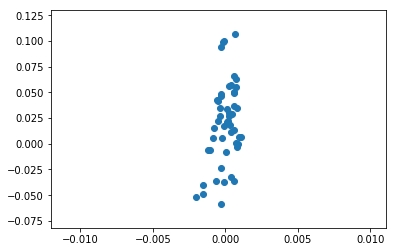

In [114]:
i = 3
data = data_df[fit_formulae[i]]
X = np.matrix(data)[:, 1:]
Y = np.matrix(data)[:, 0]
plt.scatter(np.array(X*np.matrix(fit_results[i].x).T).flatten(), Y)


print(fit_results[i].x)

beta, _, _ , _ = np.linalg.lstsq(X, Y, rcond = -1)
beta/beta[0]
results

## Marginal Effects

In [656]:
# marginal effects for each var with others at percentiles

delta = .001

for i in range(0, len(fit_formulae)):
    
    data = data_df[fit_formulae[i]]
    X = np.matrix(data)[:, 1:]
    Y = np.matrix(data)[:, 0]
    
    fit_results[i].marginal_effects = {}
    
    for j in range(0, len(fit_results[i].x)):  
        
        temp_dict = {}
        
        for percentile in range(20, 81, 20):

            X_percentile = np.percentile(X, percentile, axis = 0)
            
            temp_dict[percentile] = compute_marginal_effect(Y, X, j, np.matrix(X_percentile), np.matrix(fit_results[i].x).T, delta = delta)
            
        fit_results[i].marginal_effects[fit_formulae[i][j+1]] = temp_dict

# Export

In [657]:
from openpyxl import Workbook, load_workbook, utils
from openpyxl.styles import Alignment, Font
import string

In [658]:
def get_sig_stars(coeff, stderr, p_value_labels):
    t_stat = coeff/stderr
    p_val  = 1 - norm.cdf(np.abs(t_stat))
    below_ind = np.where([p_val < x for x in p_value_labels.keys()])[0]
    below_vals = [list(p_value_labels.keys())[i] for i in below_ind]
    if not below_vals:
        return ''
    else:
        min_p_val = np.min(below_vals)
        return p_value_labels[min_p_val]

# Params
p_value_labels = {0.05: '*', 0.01: '**', 0.001: '***'}

In [659]:
## Open workbook
wb = Workbook()

## Summary

In [660]:
ws = wb.create_sheet(title = 'Summary')
ws['B2'] = 'n'
ws['B3'] = data_df.shape[0]

## Coefficient Results

In [661]:
ws = wb.create_sheet(title = 'Coefficient Results')
ws.column_dimensions["B"].width = 30

## Label regressors 

# Get regressors besides for market share
fit_regressors = sorted(list(set(sum(fit_formulae, []))-set(['MktShare'])))
fit_regressors

regressor_cells = {}

# First label's row
regressor_label_row = 4

for i in range(0, len(fit_regressors)):

    cell = 'B' + str(regressor_label_row)
   
    ws[cell] = fit_regressors[i]
    ws[cell].alignment = Alignment(horizontal = 'right')
    ws[cell].font = Font(bold = True)
    
    regressor_cells[fit_regressors[i]] = regressor_label_row
    regressor_label_row += 2

## Label regressand
start_cell = 'C2'
end_cell   = string.ascii_uppercase[2*len(fit_results)] + '2'

ws.merge_cells(start_cell + ':' + end_cell)

ws[start_cell] = 'MktShare'
ws[start_cell].alignment = Alignment(horizontal = 'center')
ws[start_cell].font = Font(bold = True)

## Label fits
for i in range(0, len(fit_results)):
    
    cell_row = 3
    cell_col = string.ascii_uppercase[2*i + 2]
    cell = cell_col + str(cell_row)
    
    ws[cell] = 'Fit ' + str(i+1)
    ws[cell].alignment = Alignment(horizontal = 'center')
    ws[cell].font = Font(underline = 'single')
    
    # adjust cell widths
    ws.column_dimensions[cell_col].width = 15
    ws.column_dimensions[string.ascii_uppercase[2*i + 3]].width = 5

## Enter results
for i in range(0, len(fit_results)):
    
    fit_column = string.ascii_uppercase[2*i + 2]
    
    for regressor in fit_results[i].coeffs.keys():
        
        coeff = fit_results[i].coeffs[regressor]
        stderr = fit_results[i].stderrs[regressor]
        
        regressor_label_row = regressor_cells[regressor]
        cell = fit_column + str(regressor_label_row)
        cell_below = fit_column + str(regressor_label_row + 1)
        
#         if coeff == 1: 
#             coeff = str(np.round(coeff, decimals = 4))
#         else:
        coeff = str(np.round(coeff, decimals = 4)) + get_sig_stars(coeff, stderr, p_value_labels)
        
        ws[cell] = coeff
        ws[cell].alignment = Alignment(horizontal = 'center')
        
        ws[cell_below] = stderr
        ws[cell_below].alignment = Alignment(horizontal = 'center')

## Marginal Effects

In [662]:
# Set up table
for i in range(0, len(fit_results)):
    
    ws = wb.create_sheet(title = 'Fit ' + str(i+1) +' Marginal Effects')
    ws.column_dimensions["B"].width = 30
    
    fit_i_regressors = list(fit_results[i].marginal_effects.keys())
    percentiles = sorted(list((next(iter(fit_results[i].marginal_effects.values()))).keys()))
    
    ## Label regressors
    
    # First label's row
    regressor_label_row = 4
    
    regressor_cells = {}

    for j in range(0, len(fit_i_regressors)):

        cell = 'B' + str(regressor_label_row)

        ws[cell] = fit_i_regressors[j]
        ws[cell].alignment = Alignment(horizontal = 'right')
        ws[cell].font = Font(bold = True)

        regressor_cells[fit_i_regressors[j]] = regressor_label_row
        regressor_label_row += 2
        
    ## Table title label
    start_cell = 'C2'
    end_cell   = string.ascii_uppercase[2*len(percentiles)] + '2'

    ws.merge_cells(start_cell + ':' + end_cell)

    ws[start_cell] = 'Marginal Effects (MktShare)'
    ws[start_cell].alignment = Alignment(horizontal = 'center')
    ws[start_cell].font = Font(bold = True)
    
    ## Label percentiles
    for j in range(0, len(percentiles)):
        
        cell_row = 3
        cell_col = string.ascii_uppercase[2*j + 2]
        cell = cell_col + str(cell_row)

        ws[cell] = 'Pct ' + str(percentiles[j])
        ws[cell].alignment = Alignment(horizontal = 'center')
        ws[cell].font = Font(underline = 'single')
        
        # adjust cell widths
        ws.column_dimensions[cell_col].width = 15
        ws.column_dimensions[string.ascii_uppercase[2*j + 3]].width = 5

    ## Enter results
    for regressor in fit_results[i].marginal_effects.keys():
    
        me_pct_dict = fit_results[i].marginal_effects[regressor]
        
        for k in range(0, len(percentiles)):

            pct_col = string.ascii_uppercase[2*k + 2]    
            cell = pct_col + str(regressor_cells[regressor])

            ws[cell] = np.round(fit_results[i].marginal_effects[regressor][percentiles[k]], decimals = 6)
            ws[cell].alignment = Alignment(horizontal = 'center')

## Save and Close

In [663]:
del wb['Sheet']
wb.save(workbook_file_loc)
wb.close()

# Scratch

In [496]:
data_df = pd.read_csv('../data/processed/regression_data_levels_demeaned.csv')
print(data_df.shape)
data_df['Broker'].unique()

(3490, 50)


array(['Credit Suisse', 'Deutsche', 'Cowen Execution', 'Barclays Capital',
       'Securities America', 'Boenning Scattergood', 'Edward Jones',
       'Financorp Group', 'AXA', 'COR Clearing', 'DA Davidson',
       'Euro Pacific Capital', 'LPL', 'Aurora Capital',
       'Corporate Investment Group', 'E1 Asset Mgmt', 'Elish Elish',
       'Bull Market Securities', 'Fifth Third'], dtype=object)

In [497]:
def t_stats_from_fit(fit):
    stderrs = dict(fit.HC0_se)
    coeffs  = dict(fit.params)
    
    t_stats = {}
    
    for key in coeffs.keys():
        t_stats[key] = coeffs[key] / stderrs[key]
        
    return t_stats

In [498]:
import statsmodels.formula.api as sm

In [504]:
res_df = pd.DataFrame()

for broker in data_df['Broker'].unique():
    
    print(broker, end = ', ')
    print(str(data_df[data_df['Broker'].apply(lambda x: x == broker)].iloc[0]['Rebate_Dummy']))
    
    fit = sm.ols(formula = 'MktShare ~ PrImp_Pct + PrImp_AvgAmt + PrImp_AvgT', data = data_df[data_df['Broker'].apply(lambda x: x == broker)]
        ).fit()
    
    t_stats = t_stats_from_fit(fit)
    
    print('    Quality index: ' + str(t_stats['PrImp_AvgAmt'] + t_stats['PrImp_Pct'] - t_stats['PrImp_AvgT']))
    
    res_df = res_df.append({'Broker': broker, 
                            'Rebate': data_df[data_df['Broker'].apply(lambda x: x == broker)].iloc[0]['Rebate_Dummy'],
                           'Qual': (t_stats['PrImp_AvgAmt'] + t_stats['PrImp_Pct'] - t_stats['PrImp_AvgT'])}, ignore_index = True)

Credit Suisse, 1
    Quality index: -0.34068441949092554
Deutsche, 1
    Quality index: 0.04625936512448381
Cowen Execution, 0
    Quality index: nan
Barclays Capital, 1
    Quality index: -3.4508041859105765
Securities America, 0
    Quality index: -3.8380299566864595
Boenning Scattergood, 1
    Quality index: 0.36943629180953996
Edward Jones, 0
    Quality index: 10.794651745540776
Financorp Group, 0
    Quality index: -1.3270864333776446
AXA, 0
    Quality index: 4.495999746010994
COR Clearing, 0
    Quality index: -0.15747740448787512
DA Davidson, 0
    Quality index: -0.46620368231115245
Euro Pacific Capital, 0
    Quality index: 3.7832277174273132
LPL, 0
    Quality index: 3.9512002550691303
Aurora Capital, 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


0
    Quality index: 3.316970328293905
Corporate Investment Group, 0
    Quality index: 1.4136269229532723
E1 Asset Mgmt, 0
    Quality index: -0.176881986832798
Elish Elish, 0
    Quality index: 0.087776821961144
Bull Market Securities, 0
    Quality index: 5.456808694769659
Fifth Third, 0
    Quality index: -0.23514203261056665


In [506]:
res_df.sort_values('Qual')

,Broker,Qual,Rebate
4,Securities America,-3.838030,0.0
3,Barclays Capital,-3.450804,1.0
7,Financorp Group,-1.327086,0.0
10,DA Davidson,-0.466204,0.0
0,Credit Suisse,-0.340684,1.0
18,Fifth Third,-0.235142,0.0
15,E1 Asset Mgmt,-0.176882,0.0
9,COR Clearing,-0.157477,0.0
1,Deutsche,0.046259,1.0
16,Elish Elish,0.087777,0.0


In [501]:
data_df.query('Broker == "Cowen Execution" & MktShare != 0')[['MarketCenter', 'MktShare', 'PrImp_ExpAmt', 'PrImp_AvgT']]

,MarketCenter,MktShare,PrImp_ExpAmt,PrImp_AvgT


## Opt test

In [188]:
xtol = .1

In [431]:
obj_f = lambda x_0: -SLS_1(np.append(np.array([1]), x_0), Y, X, trim(X, 0.98))[0,0]
print('    Running LS...')

result1 = least_squares(obj_f, list(np.array(guess).flatten()), xtol = xtol, verbose = 1)
print(obj_f(result1.x))

print('    BFGS...')

result = minimize(obj_f, result1.x, method='BFGS', options = {'maxiter': 1})

result

    Running LS...
`xtol` termination condition is satisfied.
Function evaluations 7, initial cost 1.4803e+02, final cost 1.4645e+02, first-order optimality 5.49e-01.
17.114196558533862
    BFGS...


      fun: 17.11418627567715
 hess_inv: array([[2.49415125, 0.00629013],
       [0.00629013, 0.00498528]])
      jac: array([ 0.0320673 , -0.02669764])
  message: 'Maximum number of iterations has been exceeded.'
     nfev: 12
      nit: 1
     njev: 3
   status: 1
  success: False
        x: array([-0.00482794,  0.01704187])

In [427]:
minimize(obj_f, result1.x, method='Powell', options = {'disp': True, 'maxiter': 1})

   direc: array([[1., 0.],
       [0., 1.]])
     fun: 17.064983988866448
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 29
     nit: 1
  status: 2
 success: False
       x: array([-2.72747448,  0.01853702])

In [430]:
import numdifftools as nd

hess = nd.Hessian(obj_f)(result.x)
hess

array([[ 0.01248077,  0.04367601],
       [ 0.04367601, -0.02146611]])

In [432]:
test_f = lambda x: x[0]*x[1]

hess = nd.Hessian(test_f)
hess

In [434]:
hess([1,1])

array([[0., 1.],
       [1., 0.]])

In [438]:
point = [1,1]

test_f(point)

1

In [442]:
obj_f(np.array((result.x))*1.000001) / 1.000001**2

17.114152046746145

In [447]:
np.linalg.inv(np.array([[ 0.01248077,  0.04367601],[ 0.04367601, -0.02146611]]))

array([[ 9.86717383, 20.07624032],
       [20.07624032, -5.73694662]])

array([[ 0.01248077,  0.04367601],
       [ 0.04367601, -0.02146611]])